# Required Dependencies

In [67]:
from pgmpy.factors.discrete import TabularCPD
from pgmpy.models import DiscreteBayesianNetwork
from pgmpy.inference import VariableElimination


import networkx as nx
import numpy as np

# Exercise 1


We have the following system that classifies emails with Bayesian Networks to evaluate whether given mail is Spam observed by features:
- S: Email is a spam (S=1) or not a spam (S=0)
- O: Mail that contain "offer" (O=1) or not (O=0)
- L: Mail containing links (L=1) or not (L=0)
- M: Long Mail (M=1) or short (M=0)

Structure of the Bayesian Network
- Spam influences the probability that the email contains the word offer and contains links
- Length of email is influenced both by whether is a spam and presence of links

Conditional and Marginal Probability Distribution:

- P(S=1) = 0.4; P(S=0) = 0.6
- P(O=1 | S=1) = 0.7, P(0=1 | S=0) = 0.1
- P(L=1 | S=1) = 0.8, P(L=1|S=0) = 0.3
- P(M=1|S=1, L=1) = 0.9; P(M=1|S=1, L=0) = 0.5
- P(M=1|S=0, L=1) = 0.6; P(M=1|S=0, L=0) = 0.2

## Subpoint a
Identify dependencies of the network

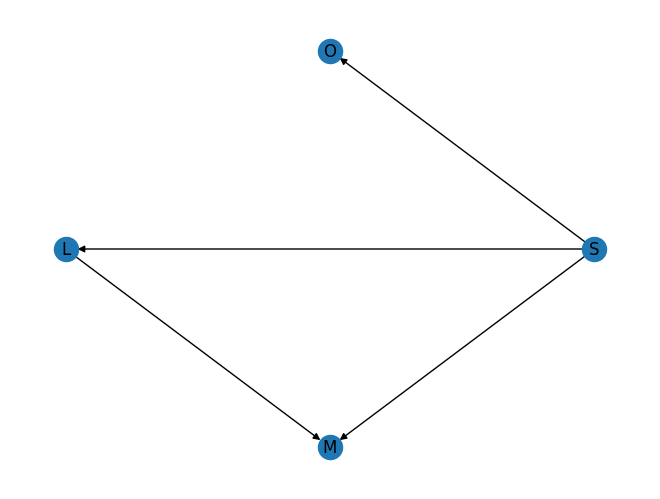

In [17]:
email_model = DiscreteBayesianNetwork([('S', 'O'), ('S', 'L'), ('S', 'M'), ('L', 'M')])
pos = nx.circular_layout(email_model)
nx.draw(email_model, with_labels=True, pos=pos)

In [18]:
email_model.local_independencies(['S', 'L', 'M', 'O'])

(L ⟂ O | S)
(M ⟂ O | L, S)
(O ⟂ L, M | S)

## Subpoint b

Determine how the Bayesian Network classifies emails based on attributes O, L, M

In [23]:
# Root of the bayesian model

cpd_s = TabularCPD(variable='S', variable_card=2, values=[
    [0.6], #P(S=0)
    [0.4]  #P(S=1)
])

# Nodes of the bayesian model with 1 parent
cpd_l = TabularCPD(variable='L', variable_card=2, values=[
    [0.9, 0.3], # P(O=0|S=0), P(O=0|S=1)
    [0.1, 0.7] # P(O=1|S=0), P(O=1|S=1)
], evidence=["S"], evidence_card=[2])
cpd_o = TabularCPD(variable='O', variable_card=2, values=[
    [0.7, 0.2], # P(L=0|S=0), P(L=0|S=1)
    [0.3, 0.8] # P(L=1|S=0), P(L=1|S=1)
], evidence=["S"], evidence_card=[2])

# Nodes of the bayesian model with 2 parents
cpd_m = TabularCPD(variable='M', variable_card=2, values=[
    [0.8, 0.4, 0.5, 0.1], # P(M=0|S=0, L=0); P(M=0|S=0, L=1); P(M=0|S=1, L=0); P(M=0|S=1, L=1)
    [0.2, 0.6, 0.5, 0.9] # P(M=1|S=0, L=0); P(M=1|S=0, L=1); P(M=1|S=1, L=0); P(M=1|S=1, L=1)
], evidence=["S", "L"], evidence_card=[2, 2])

email_model.add_cpds(cpd_s, cpd_o, cpd_l, cpd_m)

print(email_model.check_model())

True


### Variable elimination for inference

In [38]:
infer = VariableElimination(email_model)

### Case 1: Email with offer, links and is long:

In [39]:


print("="*60)
print("Example 1: O=1, L=1, M=1 (has offer, has links, is long)")
print("="*60)
result1 = infer.query(['S'], evidence={'O': 1, 'L': 1, 'M': 1})
print(result1)
print(f"\nProbability of SPAM: {result1.values[1]:.4f}")
print(f"Classification: {'SPAM' if result1.values[1] > 0.5 else 'NOT SPAM'}")

Example 1: O=1, L=1, M=1 (has offer, has links, is long)
+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.0508 |
+------+----------+
| S(1) |   0.9492 |
+------+----------+

Probability of SPAM: 0.9492
Classification: SPAM


### Case 2: Email with no offer, links, and short

In [43]:
print("\n" + "="*60)
print("Example 2: O=0, L=0, M=0 (no offer, no links, short)")
print("="*60)
result2 = infer.query(['S'], evidence={'O': 0, 'L': 0, 'M': 0})
print(result2)
print(f"\nProbability of SPAM: {result2.values[1]:.4f}")
print(f"Classification: {'SPAM' if result2.values[1] > 0.5 else 'NOT SPAM'}")


Example 2: O=0, L=0, M=0 (no offer, no links, short)
+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.9618 |
+------+----------+
| S(1) |   0.0382 |
+------+----------+

Probability of SPAM: 0.0382
Classification: NOT SPAM


### Case 3: Email with ofer, no links, short

In [44]:
print("\n" + "="*60)
print("Example 3: O=1, L=0, M=0 (has offer, no links, short)")
print("="*60)
result3 = infer.query(['S'], evidence={'O': 1, 'L': 0, 'M': 0})
print(result3)
print(f"\nProbability of SPAM: {result3.values[1]:.4f}")
print(f"Classification: {'SPAM' if result3.values[1] > 0.5 else 'NOT SPAM'}")


Example 3: O=1, L=0, M=0 (has offer, no links, short)
+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.7297 |
+------+----------+
| S(1) |   0.2703 |
+------+----------+

Probability of SPAM: 0.2703
Classification: NOT SPAM


### Case 4: It knows it has links

In [45]:
print("\n" + "="*60)
print("Example 4: L=1 (only know it has links)")
print("="*60)
result4 = infer.query(['S'], evidence={'L': 1})
print(result4)
print(f"\nProbability of SPAM: {result4.values[1]:.4f}")
print(f"Classification: {'SPAM' if result4.values[1] > 0.5 else 'NOT SPAM'}")


Example 4: L=1 (only know it has links)
+------+----------+
| S    |   phi(S) |
+======+==========+
| S(0) |   0.1765 |
+------+----------+
| S(1) |   0.8235 |
+------+----------+

Probability of SPAM: 0.8235
Classification: SPAM


### How the Bayesian Network classifies things:

1. It observes from features O, L, M from the email
2. Computes the P(S | O, L, M)
3. Decisions:
    - If P(S=1|O, L, M) > 0.5 -> Spam
    - If P(S=1 | O, L, M) <= 0.5 -> Not Spam

# Exercise 2

From Previous lab excercise 1:

We have a urn containing 3 red balls, 4 blue balls, and 2 black balls. We roll a die. If we gat a prime number then we put a black ball to the urn. If we get 6, we put a red ball in the urn, If we get something else, we put a blue ball. Then we draw 1 ball from the urn

Simulate the experiment in python and using the experiment, estimate the probability of drawing a red ball

Solve this exercise using Bayesian Network

## Solution

Here is the following model:
1. Rolling a die (D) -> The outcome of rolling a die
2. Ball adding (A) -> the color of the ball we put in the urn
3. Ball drawing (B) -> The color of the ball we draw from the urn

### Creating the model

In [58]:
urn_model = DiscreteBayesianNetwork([('D', 'A'), ('A', 'B')])

### Computing the CPD

In [59]:

# Die roll cpd. We have 6 outcomes for each face.
# Root of the bayesian model
cpd_die = TabularCPD(variable='D', variable_card=6, values=[
    [1/6],[1/6],[1/6],[1/6],[1/6],[1/6] # probability of each face is 1/6
])

# Ball adding given the die roll D
# Node with 1 parent

cpd_add = TabularCPD(variable='A', variable_card=3, values=[
    [0, 0, 0, 0, 0, 1], # If given number is 6
    [1, 0, 0, 1, 0, 0], # If given number is not prime
    [0, 1, 1, 0, 1, 0] # If given number is prime
], evidence=['D'], evidence_card=[6])

cpd_draw = TabularCPD(variable='B', variable_card=3,values=[
        [4/10, 3/10, 3/10],  # P(B=red | A) - after adding red/blue/black
        [4/10, 5/10, 4/10],  # P(B=blue | A)
        [2/10, 2/10, 3/10]   # P(B=black | A)
    ],
    evidence=['A'],
    evidence_card=[3]
)

### Adding the CPD to the model

In [60]:
urn_model.add_cpds(cpd_die, cpd_add, cpd_draw)

### Verify

In [61]:
print(urn_model.check_model())

True


### Perform Inference

In [62]:
infer = VariableElimination(urn_model)

### Query the probability of drawing a red ball

In [65]:
result = infer.query(['B'])
print("\nProbability distribution of drawn ball:")
print(result)
print(f"\nProbability of drawing RED ball: {result.values[0]:.4f}")
print(f"Probability of drawing BLUE ball: {result.values[1]:.4f}")
print(f"Probability of drawing BLACK ball: {result.values[2]:.4f}")


Probability distribution of drawn ball:
+------+----------+
| B    |   phi(B) |
+======+==========+
| B(0) |   0.3167 |
+------+----------+
| B(1) |   0.4333 |
+------+----------+
| B(2) |   0.2500 |
+------+----------+

Probability of drawing RED ball: 0.3167
Probability of drawing BLUE ball: 0.4333
Probability of drawing BLACK ball: 0.2500


### EXTRA: Viewing the Bayesian Network

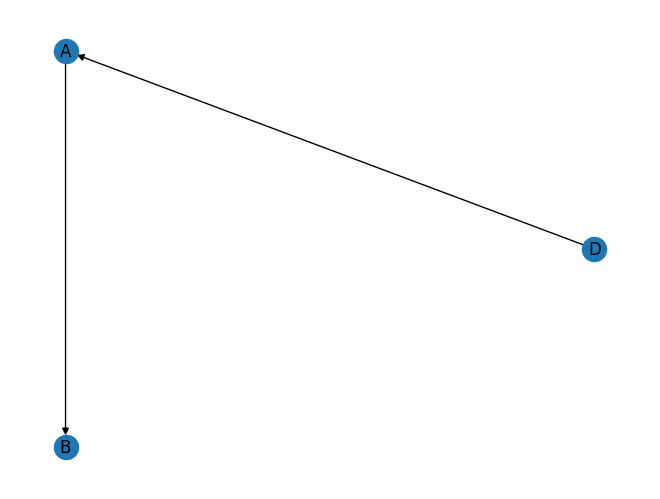

In [66]:
pos = nx.circular_layout(urn_model)
nx.draw(urn_model, with_labels=True, pos=pos)

# Exercise 3

A game between P0 and P1 that follows:

- A (fair) coin is tossed to decide the first move P0 or P1
- The first round, the designated player rolls a die; n being the number obtained
- Second round, the player flips their own coin 2*n times; m being the number of heads obtained.

The player from the first round wins if n >= , otherwise the second-round player wins. also P1 is dishonest and brought a rigged coin with probability of head = 4/7 in contrast with P0's coin with fair coin and both player's die is fair

a) Estimate which of the 2 player has the higher chance of winning simulating the game 10000 times
b) Using pgmpy, define the Bayesian Network defined above
c) Using the model, determine who is most likely to start the game knowing that only one head was obtained in second round

### Solution a

### Simulating the game

In [105]:
def game_simulation():
    first_player = np.random.choice([0, 1]) # player 1 or player 0

    n = np.random.randint(1, 7) # number of die face

    toss_number = 2*n # number of tosses determined by face

    if first_player == 0: # probability of coin landing head based of player
        coin_prob = 1/2
    else:
        coin_prob = 4/7

    flips = np.random.random(toss_number) < coin_prob # list of consecutive flips whether is head or not

    m = np.sum(flips) # counting the number of heads

    if n>=m:
        winner = first_player
    else:
        winner = 1-first_player

    return winner

print(game_simulation())

1


### Simulating the game 10000 times

In [117]:
nr_simulatons = 10000

result = [game_simulation() for _ in range(game_simulation())]

p0_wins = result.count(0)
p1_wins = result.count(1)

p0_prob = p0_wins / nr_simulatons
p1_prob = p1_wins / nr_simulatons

print(f"Number of games won by P0: {p0_wins} Prob: {p0_prob}")
print(f"Number of games won by P1: {p1_wins} Prob: {p1_prob}")

if p0_prob > p1_prob:
    print("P0 is most likely to win")
else:
    print("P1 is most likely to win")

Number of games won by P0: 0 Prob: 0.0
Number of games won by P1: 1 Prob: 0.0001
P1 is most likely to win
